In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from collections import Counter

from tensorflow import keras
from tensorflow.keras import models, layers

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import decode_predictions

2022-12-22 05:13:49.323007: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def render_history(history):
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Our losses")
    plt.show()
    plt.close()

    plt.plot(history["accuracy"], label="accuracy")
    plt.plot(history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.title("Our accuracies")
    plt.show()
    plt.close()
    
        
def augment_sobel(image, label):
    sobel = tf.image.sobel_edges(image)
    sobel_y = (sobel[..., 0] / 4 + 0.5)
    return sobel_y, label
 
    
def augment_gray(image, label):
    gray = tf.image.rgb_to_grayscale(image)
    return gray, label
 
    
def augment_contrast(image, label):
    contrast = tf.image.random_contrast(image, 0.1, 0.5)
    return contrast, label


def model_pretrained_arch1(learning_rate):
    
    model = models.Sequential()

    model.add(layers.InputLayer(input_shape=(299, 299, 3)))
    
    model.add(layers.Rescaling(1./127.5, offset=-1))
    model.add(layers.RandomFlip("horizontal_and_vertical"))
    model.add(layers.RandomRotation(0.2))

    model.add(pre_trained_model)

    model.add(layers.Conv2D(32, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(32, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  
    
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.8)

    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [3]:
image_size = (299, 299)
batch_size = 32
# epochs = 100

In [4]:
train_ds = image_dataset_from_directory(
    '../dat/train/', 
    seed=4231,
    image_size=image_size, 
    shuffle=True,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)


val_ds = image_dataset_from_directory(
    '../dat/val/', 
    seed=4231,
    image_size=image_size, 
    shuffle=True,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

test_ds = image_dataset_from_directory(
    '../dat/test/', 
    seed=4231,
    image_size=image_size, 
    shuffle=False,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

Found 2816 files belonging to 2 classes.


2022-12-22 05:13:51.254319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 05:13:51.262314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 05:13:51.262928: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 05:13:51.263868: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Found 412 files belonging to 2 classes.
Found 764 files belonging to 2 classes.


In [5]:
train_aug_ds = train_ds.map(augment_sobel)
train_aug_ds = train_aug_ds.map(augment_contrast)
train_aug_gray_ds = train_aug_ds.map(augment_gray) 

test_aug_ds = test_ds.map(augment_sobel)
test_aug_ds = test_aug_ds.map(augment_contrast) 
test_aug_gray_ds = test_aug_ds.map(augment_gray) 

In [6]:
class_names = train_ds.class_names
print(class_names)

['female', 'male']


In [7]:
pre_trained_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(299, 299, 3)
)

# freeze convolutional layers and don't include dense layers
pre_trained_model.trainable = False
# pre_trained_model.summary()

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


# train_aug_ds = train_aug_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_aug_ds = val_aug_ds.cache().prefetch(buffer_size=AUTOTUNE)

train_aug_gray_ds = train_aug_gray_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_aug__gray_ds = test_aug_gray_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
# lr_sched = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-1 * (0.80 ** np.floor(epoch / 2)))

In [10]:
model = model_pretrained_arch1(0.001)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 299, 299, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 299, 299, 3)      0         
 tion)                                                           
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 conv2d_94 (Conv2D)          (None, 8, 8, 32)          589856    
                                                                 
 batch_normalization_94 (Bat  (None, 8, 8, 32)         128       
 chNormalization)                                       

In [11]:
history_list = {}

In [12]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'inception_v1_{epoch:03d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [13]:
history = model.fit(
    train_ds,
    batch_size=20,
    epochs=100,
    validation_data=test_ds, 
    # callbacks=[lr_sched]
    callbacks=[checkpoint]
)

history_list['model_1'] = history.history

Epoch 1/100


2022-12-22 05:14:02.358716: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-12-22 05:14:03.021187: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-22 05:14:03.022070: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-22 05:14:03.022111: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-22 05:14:03.023091: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-22 05:14:03.023197: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


88/88 [==============================] - 45s 401ms/step - loss: 0.7355 - accuracy: 0.5185 - val_loss: 0.7056 - val_accuracy: 0.4385
Epoch 2/100
88/88 [==============================] - 14s 159ms/step - loss: 0.7034 - accuracy: 0.5288 - val_loss: 0.6948 - val_accuracy: 0.4869
Epoch 3/100
88/88 [==============================] - 14s 160ms/step - loss: 0.6988 - accuracy: 0.5170 - val_loss: 0.6898 - val_accuracy: 0.5353
Epoch 4/100
88/88 [==============================] - 14s 159ms/step - loss: 0.6996 - accuracy: 0.5277 - val_loss: 0.6900 - val_accuracy: 0.5524
Epoch 5/100
88/88 [==============================] - 14s 154ms/step - loss: 0.6943 - accuracy: 0.5398 - val_loss: 0.6890 - val_accuracy: 0.5471
Epoch 6/100
88/88 [==============================] - 14s 159ms/step - loss: 0.6906 - accuracy: 0.5430 - val_loss: 0.6882 - val_accuracy: 0.5628
Epoch 7/100
88/88 [==============================] - 14s 154ms/step - loss: 0.6920 - accuracy: 0.5423 - val_loss: 0.6871 - val_accuracy: 0.5550
Epoc

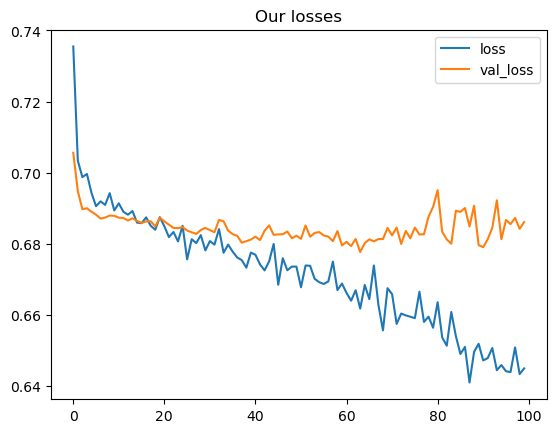

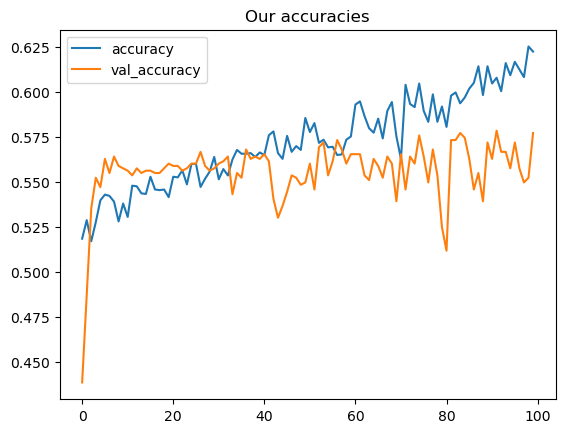

In [14]:
render_history(history.history)

In [15]:
initial_epochs = 100
add_epochs = 100

total_epochs =  initial_epochs + add_epochs

history_add = model.fit(
    train_ds,
    batch_size=20,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=test_ds, 
    # callbacks=[lr_sched]
    callbacks=[checkpoint]
)

history_list['model_1_add'] = history_add.history

Epoch 100/200
88/88 [==============================] - 13s 153ms/step - loss: 0.6371 - accuracy: 0.6147 - val_loss: 0.6870 - val_accuracy: 0.5419
Epoch 101/200
88/88 [==============================] - 14s 159ms/step - loss: 0.6475 - accuracy: 0.6261 - val_loss: 0.6916 - val_accuracy: 0.5798
Epoch 102/200
88/88 [==============================] - 14s 154ms/step - loss: 0.6387 - accuracy: 0.6193 - val_loss: 0.6851 - val_accuracy: 0.5628
Epoch 103/200
88/88 [==============================] - 13s 154ms/step - loss: 0.6397 - accuracy: 0.6282 - val_loss: 0.6882 - val_accuracy: 0.5484
Epoch 104/200
88/88 [==============================] - 14s 154ms/step - loss: 0.6515 - accuracy: 0.6175 - val_loss: 0.6843 - val_accuracy: 0.5301
Epoch 105/200
88/88 [==============================] - 13s 154ms/step - loss: 0.6376 - accuracy: 0.6076 - val_loss: 0.6798 - val_accuracy: 0.5707
Epoch 106/200
88/88 [==============================] - 13s 153ms/step - loss: 0.6442 - accuracy: 0.6261 - val_loss: 0.6898 -

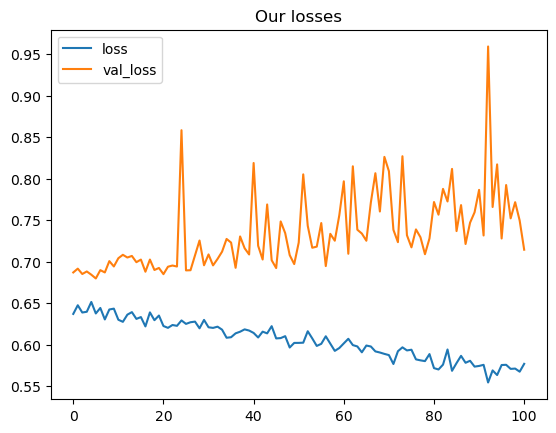

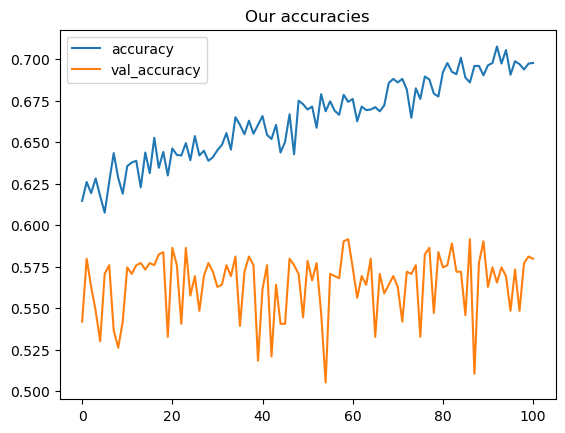

In [18]:
render_history(history_add.history)

In [132]:
acc = history_list['model_1']['accuracy']
val_acc = history_list['model_1']['val_accuracy']

loss = history_list['model_1']['loss']
val_loss = history_list['model_1']['val_loss']

In [133]:
acc += history_add.history['accuracy']
val_acc += history_add.history['val_accuracy']

loss += history_add.history['loss']
val_loss += history_add.history['val_loss']

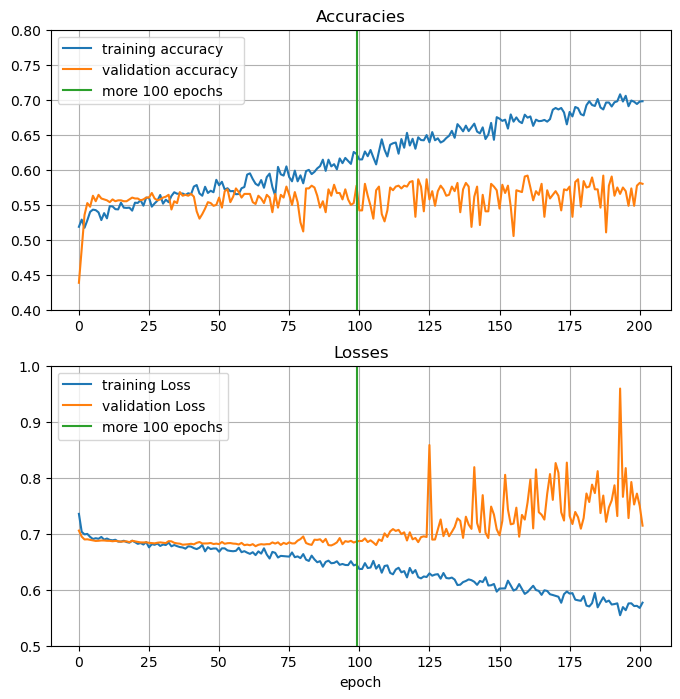

In [138]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='training accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.ylim([0.4, 0.8])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='more 100 epochs')
plt.legend(loc='best')
plt.grid()
plt.title('Accuracies')

plt.subplot(2, 1, 2)
plt.plot(loss, label='training Loss')
plt.plot(val_loss, label='validation Loss')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='more 100 epochs')
plt.legend(loc='best')
plt.title('Losses')
plt.xlabel('epoch')
plt.grid()
plt.show()

In [140]:
# len(history_list['model_1']['accuracy'])

In [141]:
#len(history_list['model_1_add']['accuracy'])
#h_list = history_list['model_1']['accuracy']
#h_list = history_list['model_1']['val_accuracy']
# h_list = history_list['model_1']['val_loss']

In [142]:
# n_list = h_list[:101]

In [143]:
# len(n_list)

In [144]:
#history_list['model_1']['val_loss'] = n_list

In [149]:
initial_epochs = 200
add_epochs = 50

total_epochs =  initial_epochs + add_epochs

history_add = model.fit(
    train_aug_ds,
    batch_size=20,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=test_aug_ds, 
    # callbacks=[lr_sched]
    callbacks=[checkpoint]
)

history_list['model_1_add'] = history_add.history

Epoch 100/250
88/88 [==============================] - 38s 406ms/step - loss: 0.7557 - accuracy: 0.4822 - val_loss: 0.7297 - val_accuracy: 0.4398
Epoch 101/250
88/88 [==============================] - 38s 403ms/step - loss: 0.7033 - accuracy: 0.4915 - val_loss: 0.7108 - val_accuracy: 0.4476
Epoch 102/250
88/88 [==============================] - 38s 403ms/step - loss: 0.6982 - accuracy: 0.4904 - val_loss: 0.6974 - val_accuracy: 0.5105
Epoch 103/250
88/88 [==============================] - 38s 403ms/step - loss: 0.6915 - accuracy: 0.5334 - val_loss: 0.6921 - val_accuracy: 0.5223
Epoch 104/250
88/88 [==============================] - 37s 402ms/step - loss: 0.6908 - accuracy: 0.5192 - val_loss: 0.6934 - val_accuracy: 0.4908
Epoch 105/250
88/88 [==============================] - 38s 403ms/step - loss: 0.6888 - accuracy: 0.5192 - val_loss: 0.6900 - val_accuracy: 0.5327
Epoch 106/250
88/88 [==============================] - 37s 400ms/step - loss: 0.6886 - accuracy: 0.5558 - val_loss: 0.6897 -

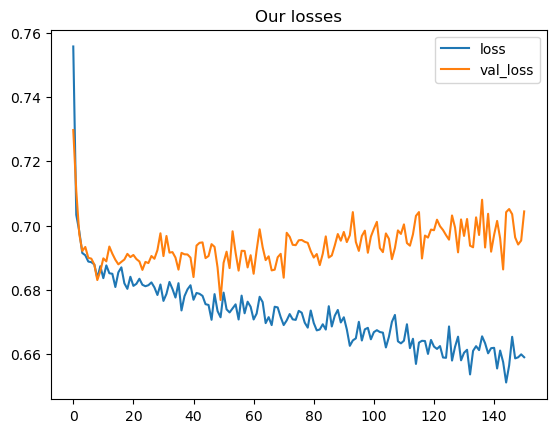

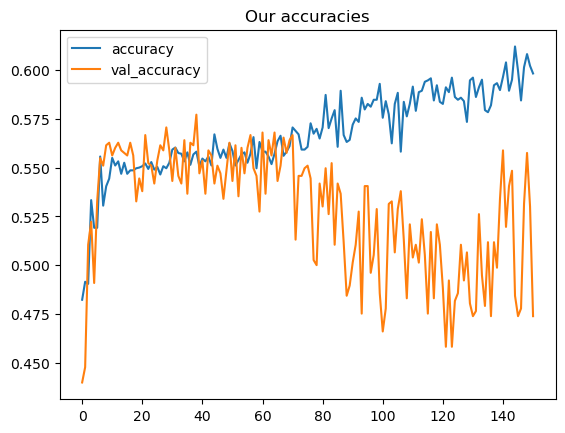

In [150]:
render_history(history_add.history)